# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [1]:
!pip install scipy=='1.0.0'

     |████████████████████████████████| 50.0MB 58kB/s 
ERROR: umap-learn 0.4.4 has requirement scipy>=1.3.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.0.0 which is incompatible.
ERROR: seaborn 0.10.1 has requirement scipy>=1.0.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.0.0 which is incompatible.
ERROR: cvxpy 1.0.31 has requirement scipy>=1.1.0, but you'll have scipy 1.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [4]:
data.shape

(13143, 45, 45, 3)

In [5]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val:

In [6]:
X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE]
X_train = np.array(X_train, np.float32) / 255
X_val = np.array(X_val, np.float32) / 255

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [7]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

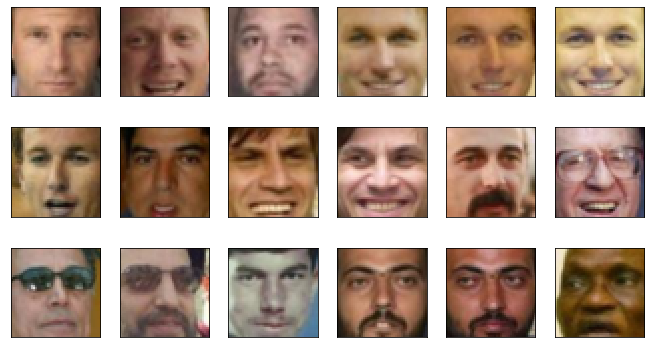

In [8]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [11]:
inp_size=X_train.shape[1]
dim_code = 100 # размер латентного вектора, т.е. code

In [12]:
inp_size

45

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [13]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()

      # encoder (downsampling)
      self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 32, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32),
                                    nn.Conv2d(32, 32, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32))
      self.pool0 = nn.MaxPool2d(3)

      self.enc_conv1 = nn.Sequential(nn.Conv2d(32, 64, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64),
                                    nn.Conv2d(64, 64, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64))
      self.pool1 = nn.MaxPool2d(3);

      self.enc_conv2 = nn.Sequential(nn.Conv2d(64, 100, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(100),
                                    nn.Conv2d(100, 100, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(100))
      self.pool2 = nn.MaxPool2d(5);

      # decoder (upsampling)

      self.upsample1 = nn.Upsample(scale_factor=5, mode='bilinear')
      self.dec_conv1 = nn.Sequential(nn.Conv2d(100, 100, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(100),
                                    nn.Conv2d(100, 64, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64))
      self.upsample2 = nn.Upsample(scale_factor=3, mode='bilinear')
      self.dec_conv2 = nn.Sequential(nn.Conv2d(64, 64, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64),
                                    nn.Conv2d(64, 32, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32))
      self.upsample3 = nn.Upsample(scale_factor=3, mode='bilinear')
      self.dec_conv3 = nn.Sequential(nn.Conv2d(32, 32, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32),
                                    nn.Conv2d(32, 3, (3, 3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(3))

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x.to(device)))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))

        # decoder
        d1 = self.dec_conv1(self.upsample1(e2))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))
        return d3, e2 #reconstruction, latent_code

In [14]:
from torchsummary import summary 
model = Autoencoder().to(device)
summary(model, (3, 45, 45))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 45, 45]             896
              ReLU-2           [-1, 32, 45, 45]               0
       BatchNorm2d-3           [-1, 32, 45, 45]              64
            Conv2d-4           [-1, 32, 45, 45]           9,248
              ReLU-5           [-1, 32, 45, 45]               0
       BatchNorm2d-6           [-1, 32, 45, 45]              64
         MaxPool2d-7           [-1, 32, 15, 15]               0
            Conv2d-8           [-1, 64, 15, 15]          18,496
              ReLU-9           [-1, 64, 15, 15]               0
      BatchNorm2d-10           [-1, 64, 15, 15]             128
           Conv2d-11           [-1, 64, 15, 15]          36,928
             ReLU-12           [-1, 64, 15, 15]               0
      BatchNorm2d-13           [-1, 64, 15, 15]             128
        MaxPool2d-14             [-1, 6

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [15]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [17]:
from torch.utils.data import DataLoader
batch_size = 32

data_tr = DataLoader(list(np.rollaxis(X_train.numpy(), 3, 1)), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(np.rollaxis(X_val.numpy(), 3, 1)), 
                     batch_size=batch_size, shuffle=True)


In [18]:
from time import time

In [19]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val = next(iter(data_val))
    tr_loss = []
    val_loss = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch in data_tr:
            X_batch = X_batch.to(device)

            opt.zero_grad()

            Y_pred, code = model(X_batch)
            Y_pred = Y_pred.to(device)
            loss = loss_fn(X_batch, Y_pred)
            loss.backward()
            opt.step()

            avg_loss += loss / len(data_tr)
        tr_loss.append(avg_loss)
        toc = time()
        print('loss: %f' % avg_loss)
        
        model.eval()
        reconstruction, code = model(X_val.to(device))

        reconstruction = reconstruction.detach().cpu()
        val_loss.append(loss_fn(X_val, reconstruction))

        plot_gallery([np.rollaxis(X_val[0].numpy(), 0, 3), np.rollaxis(reconstruction[0].numpy(), 0, 3)], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return tr_loss, val_loss

* Epoch 1/25


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.667717


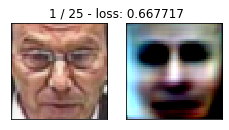

* Epoch 2/25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.239909


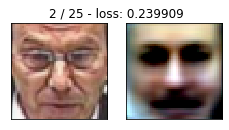

* Epoch 3/25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: 0.077615


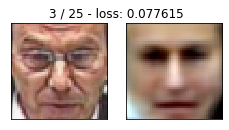

* Epoch 4/25
loss: 0.023416


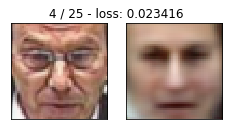

* Epoch 5/25
loss: 0.009254


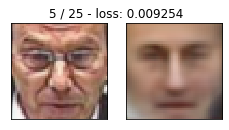

* Epoch 6/25
loss: 0.009078


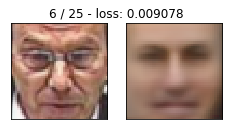

* Epoch 7/25
loss: 0.008400


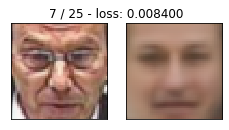

* Epoch 8/25
loss: 0.007109


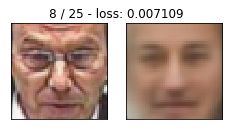

* Epoch 9/25
loss: 0.006565


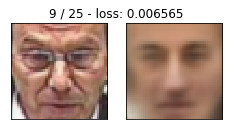

* Epoch 10/25
loss: 0.006163


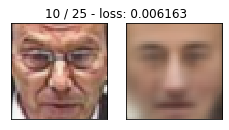

* Epoch 11/25
loss: 0.006068


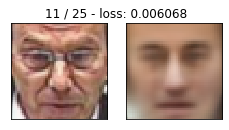

* Epoch 12/25
loss: 0.005822


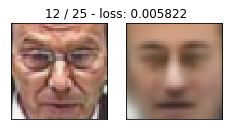

* Epoch 13/25
loss: 0.005685


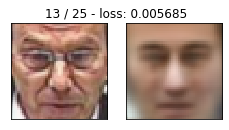

* Epoch 14/25
loss: 0.005602


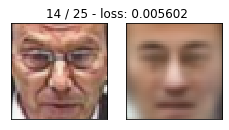

* Epoch 15/25
loss: 0.005421


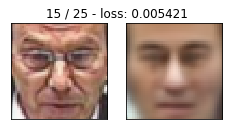

* Epoch 16/25
loss: 0.005383


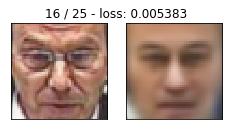

* Epoch 17/25
loss: 0.005227


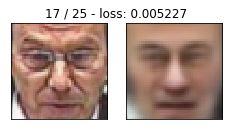

* Epoch 18/25
loss: 0.005079


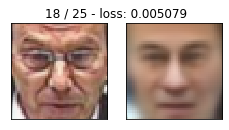

* Epoch 19/25
loss: 0.005017


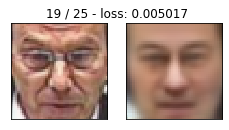

* Epoch 20/25
loss: 0.004902


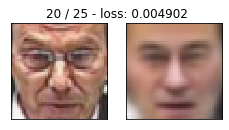

* Epoch 21/25
loss: 0.004823


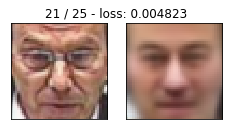

* Epoch 22/25
loss: 0.004735


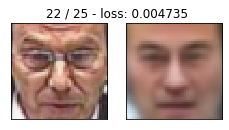

* Epoch 23/25
loss: 0.004556


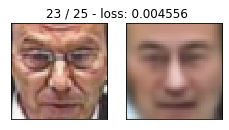

* Epoch 24/25
loss: 0.004558


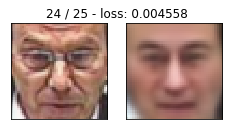

* Epoch 25/25
loss: 0.004466


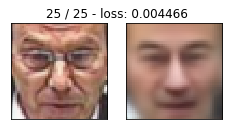

In [20]:
tr_loss, val_loss = train(model, optimizer, criterion, 25, data_tr, data_val)

Графики лосса

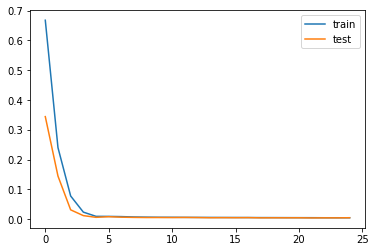

In [21]:
plt.plot(tr_loss, label='train')
plt.plot(val_loss, label='test')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


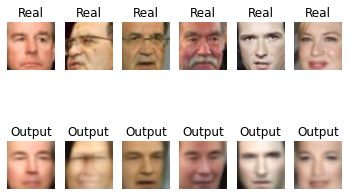

In [22]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
X = 6
model.eval()

X_val = next(iter(data_val))
Y_hat, code = model(X_val.to(device))
Y_hat = Y_hat.detach().cpu()

for k in range(X):
    plt.subplot(2, X, k+1)
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3))
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, X, k+7)
    plt.imshow(np.rollaxis(Y_hat[k].numpy(), 0, 3))
    plt.title('Output')
    plt.axis('off')
plt.show()

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

In [23]:
decoder = nn.Sequential(*list(model.children())[6:])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(25, 3, 45, 45)
(25, 45, 45, 3)


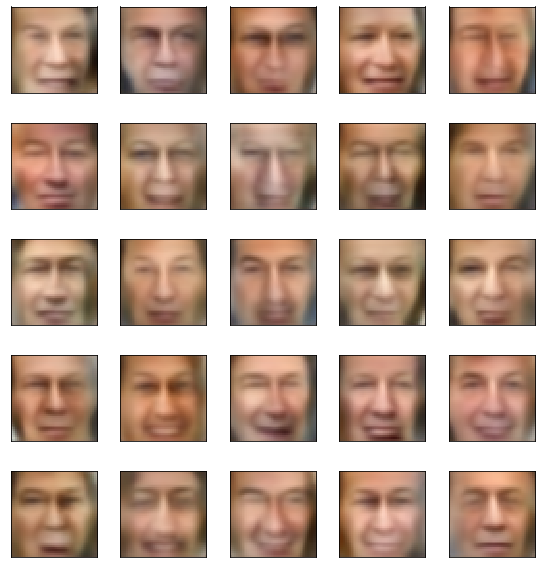

In [24]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.array(np.random.randn(25, 100, 1, 1), dtype='float32') + 3.3
z = torch.tensor(z)
decoder.eval()
output = decoder(z.to(device)).detach().cpu()
print(output.numpy().shape)
output = np.rollaxis(output.numpy(), 1, 4)
print(output.shape)
plot_gallery(output, IMAGE_H, IMAGE_W, n_row=5, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [25]:
sad_15 = attrs.sort_values('Smiling').head(15).index
happy_15 = attrs.sort_values('Smiling').tail(15).index

In [26]:
happy_img = data[happy_15]
sad_img = data[sad_15]

happy_img = np.array(happy_img, np.float32) / 255
sad_img = np.array(sad_img, np.float32) / 255

In [27]:
happy_tr = np.rollaxis(happy_img, 3, 1)
sad_tr = np.rollaxis(sad_img, 3, 1)

happy_tr = torch.from_numpy(happy_tr)
sad_tr = torch.from_numpy(sad_tr)

In [28]:
model.eval()
rec, happy_code = model(happy_tr.to(device))
rec, sad_code = model(sad_tr.to(device))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [29]:
smile = happy_code.mean(0) - sad_code.mean(0)

In [30]:
smile.shape

torch.Size([100, 1, 1])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


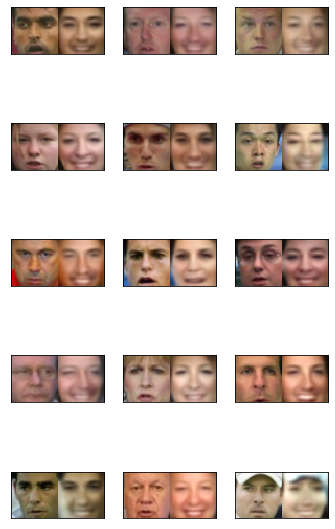

In [31]:
decoder.eval()
output = decoder((sad_code + smile).to(device)).detach().cpu()
output = np.rollaxis(output.numpy(), 1, 4)
plot_gallery(np.concatenate((sad_img, output), axis=2), IMAGE_H, IMAGE_W * 2, n_row=5, n_col=3)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 32, (3, 3), padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(32),
                                      nn.Conv2d(32, 32, (3, 3), padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(32))
        self.pool0 = nn.MaxPool2d(3)

        self.enc_conv1 = nn.Sequential(nn.Conv2d(32, 64, (3, 3), padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(64),
                                      nn.Conv2d(64, 64, (3, 3), padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(64))
        self.pool1 = nn.MaxPool2d(3);

        self.fc1 = nn.Linear(1600, 100)
        self.fc2 = nn.Linear(1600, 100)

        # decoder (upsampling)

        self.upsample1 = nn.Upsample(scale_factor=5, mode='bilinear')
        self.dec_conv1 = nn.Sequential(nn.Conv2d(100, 100, (3, 3), padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(100),
                                      nn.Conv2d(100, 64, (3, 3), padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(64))
        self.upsample2 = nn.Upsample(scale_factor=3, mode='bilinear')
        self.dec_conv2 = nn.Sequential(nn.Conv2d(64, 64, (3, 3), padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(64),
                                      nn.Conv2d(64, 32, (3, 3), padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(32))
        self.upsample3 = nn.Upsample(scale_factor=3, mode='bilinear')
        self.dec_conv3 = nn.Sequential(nn.Conv2d(32, 32, (3, 3), padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(32),
                                      nn.Conv2d(32, 3, (3, 3), padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(3),
                                      nn.Sigmoid())

    def encode(self, x):
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        X = torch.reshape(e1, (-1, 64 * 5 * 5))
        mu = self.fc1(X)
        logsigma = self.fc2(X)

        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.mul(0.5).exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add(mu)
        else:
            return mu
    
    def decode(self, z):
        Z = torch.reshape(z, (-1, 100, 1, 1))
        d1 = self.dec_conv1(self.upsample1(Z))
        d2 = self.dec_conv2(self.upsample2(d1))
        reconstruction = self.dec_conv3(self.upsample3(d2))
        
        return reconstruction

    def forward(self, x):
        mu, sigma = self.encode(x.to(device))
        reconstruction = self.decode(self.gaussian_sampler(mu, sigma))
        return mu, sigma, reconstruction

In [ ]:
from torchsummary import summary 
autoencoder = VAE().to(device)
summary(autoencoder, (3, 45, 45))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 45, 45]             896
              ReLU-2           [-1, 32, 45, 45]               0
       BatchNorm2d-3           [-1, 32, 45, 45]              64
            Conv2d-4           [-1, 32, 45, 45]           9,248
              ReLU-5           [-1, 32, 45, 45]               0
       BatchNorm2d-6           [-1, 32, 45, 45]              64
         MaxPool2d-7           [-1, 32, 15, 15]               0
            Conv2d-8           [-1, 64, 15, 15]          18,496
              ReLU-9           [-1, 64, 15, 15]               0
      BatchNorm2d-10           [-1, 64, 15, 15]             128
           Conv2d-11           [-1, 64, 15, 15]          36,928
             ReLU-12           [-1, 64, 15, 15]               0
      BatchNorm2d-13           [-1, 64, 15, 15]             128
        MaxPool2d-14             [-1, 6

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = mu.pow(2).add(logsigma.exp()).mul(-1).add(1).add(logsigma)
    return torch.sum(loss).mul(-0.5)

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.MSELoss(size_average=False)
    return loss(x, reconstruction)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 128

data_tr = DataLoader(list(np.rollaxis(X_train.numpy(), 3, 1)), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(np.rollaxis(X_val.numpy(), 3, 1)), 
                     batch_size=batch_size, shuffle=True)

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val = next(iter(data_val))
    tr_loss = []
    val_loss = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch in data_tr:
            X_batch = X_batch.to(device)

            opt.zero_grad()

            mu, sigma, Y_pred = model(X_batch)
            loss = loss_fn(X_batch, mu, sigma, Y_pred)
            loss.backward()
            opt.step()

            avg_loss += loss / len(data_tr)
        tr_loss.append(avg_loss)
        print('loss: %f' % avg_loss)

        model.eval()
        mu, sigma, reconstruction = model(X_val.to(device))

        reconstruction = reconstruction.detach().cpu()
        val_loss.append(loss_fn(X_val, mu, sigma, reconstruction))

        # Visualize tools
        clear_output(wait=True)
        plot_gallery([np.rollaxis(X_val[0].numpy(), 0, 3), np.rollaxis(reconstruction[0].numpy(), 0, 3)], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return tr_loss, val_loss

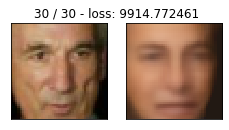

In [ ]:
tr_loss, val_loss = train(autoencoder, optimizer, criterion, 30, data_tr, data_val)

Графики лосса

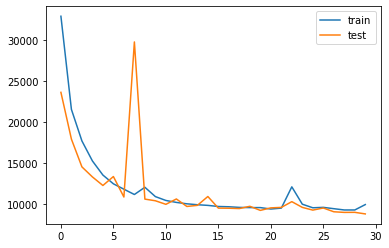

In [ ]:
plt.plot(tr_loss, label='train')
plt.plot(val_loss, label='test')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


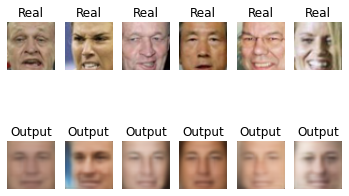

In [ ]:
X = 6
autoencoder.eval() 

next_val = next(iter(data_val))
mu, sigma, reconstruction = autoencoder(next_val.to(device))
reconstruction = reconstruction.detach().cpu()

for k in range(X):
    plt.subplot(2, X, k+1)
    plt.imshow(np.rollaxis(next_val[k].numpy(), 0, 3))
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, X, k+7)
    plt.imshow(np.rollaxis(reconstruction[k].numpy(), 0, 3))
    plt.title('Output')
    plt.axis('off')
plt.show()

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(10, 3, 45, 45)
(10, 45, 45, 3)


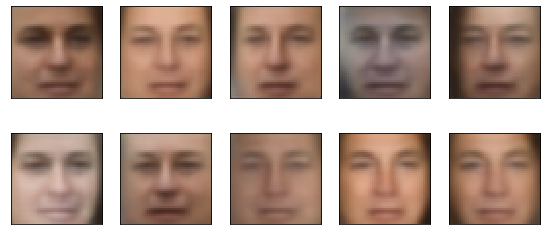

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)]).astype(np.float32)
z = torch.tensor(z)
autoencoder.eval()
output = autoencoder.decode(z.to(device)).detach().cpu()
output = np.rollaxis(output.numpy(), 1, 4)
plot_gallery(output, IMAGE_H, IMAGE_W, n_row=2, n_col=5)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
test_data = data[val]
test_data = np.rollaxis(np.array(test_data, np.float32) / 255, 3, 1)
test_data = torch.from_numpy(test_data).contiguous()

In [ ]:
autoencoder.eval()
mu, logsigma = autoencoder.encode(test_data.to(device))
latent_vectors = autoencoder.gaussian_sampler(mu, logsigma)
latent_vectors = latent_vectors.detach().cpu()

In [ ]:
import sklearn.manifold

In [ ]:
compressed_vectors = sklearn.manifold.TSNE(n_components=2).fit_transform(latent_vectors)
vectors_map = np.hstack((compressed_vectors, val.reshape(-1, 1)))

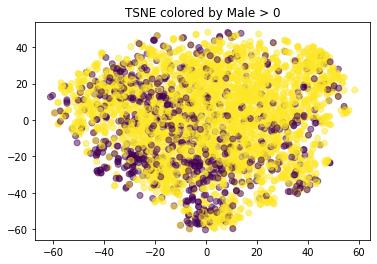

In [ ]:
plt.scatter(vectors_map[:, 0], vectors_map[:, 1], c=(attrs.iloc[vectors_map[:, 2]].Male > 0), alpha=0.5)
plt.title('TSNE colored by Male > 0')
plt.show()

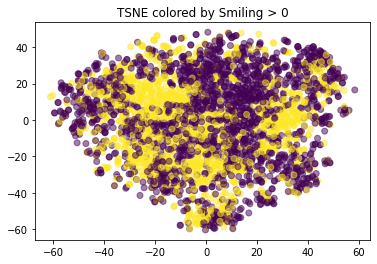

In [ ]:
plt.scatter(vectors_map[:, 0], vectors_map[:, 1], c=(attrs.iloc[vectors_map[:, 2]].Smiling > 0), alpha=0.5)
plt.title('TSNE colored by Smiling > 0')
plt.show()

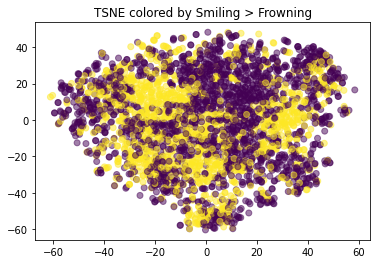

In [ ]:
plt.scatter(vectors_map[:, 0], vectors_map[:, 1], c=(attrs.iloc[vectors_map[:, 2]].Smiling > attrs.iloc[vectors_map[:, 2]].Frowning), alpha=0.5)
plt.title('TSNE colored by Smiling > Frowning')
plt.show()

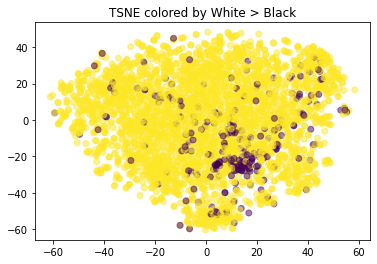

In [ ]:
plt.scatter(vectors_map[:, 0], vectors_map[:, 1], c=(attrs.iloc[vectors_map[:, 2]].White > attrs.iloc[vectors_map[:, 2]].Black), alpha=0.5)
plt.title('TSNE colored by White > Black')
plt.show()

Что вы думаете о виде латентного представления?

Видно, что векторы с одинаковыми признаками немного сгруппированы

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [42]:
from torchvision import transforms, datasets

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64,
                                          shuffle=True)

valset = datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
valloader = DataLoader(valset, batch_size=64,
                        shuffle=False)
classes = tuple(str(i) for i in range(10))

In [43]:
class Autoencoder_MNIST(nn.Module):
    def __init__(self, latent=250):
        super().__init__()
        self.latent = latent
        #на вход (28, 28)+ one_hot
        self.fc_encode = nn.Sequential(nn.Linear(28*28, 28*28),
                                 nn.LeakyReLU(0.2))#попробовать поменять на sigmoid
        #выход (28,28)
        self.conv1_down = nn.Sequential(nn.Conv2d(1, 20, 3, padding=1),
                                        nn.BatchNorm2d(20),
                                        nn.LeakyReLU(0.2),
        )
        self.conv2_down = nn.Sequential(nn.Conv2d(20, 40, 3),
                                        nn.BatchNorm2d(40),
                                        nn.LeakyReLU(0.2),
                                        nn.MaxPool2d(2)
        ) 
        self.conv3_down = nn.Sequential(nn.Conv2d(40, 60, 3),
                                        nn.BatchNorm2d(60),
                                        nn.LeakyReLU(0.2),
        )
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(60*5*5, latent)
        #выход 250
        self.fc2 = nn.Sequential(nn.Linear(latent, 60*5*5),
                                 nn.LeakyReLU(0.2)
        )
        self.conv3_up = nn.Sequential(nn.ConvTranspose2d(60, 40, 3, stride=2),
                                      nn.BatchNorm2d(40),# формула size+(size-1) + (pad)*2 - (kernel-1), где pad = 0, если padding=2, 1, если 1, 2, если 0 и еще padding зависит от kernel (pad = 2 для 3, pad=3 для 4)
                                      nn.LeakyReLU(0.2)

        )
        self.conv2_up = nn.Sequential(nn.ConvTranspose2d(40, 20, 3, stride = 1),
                                      nn.BatchNorm2d(20),
                                      nn.LeakyReLU(0.2)
        )
        self.conv1_up = nn.Sequential(nn.ConvTranspose2d(20, 10, 3, stride=1),
                                      nn.BatchNorm2d(10),
                                      nn.LeakyReLU(0.2),
                                      nn.ConvTranspose2d(10, 5, 3, stride=2, padding = 1),
                                      nn.BatchNorm2d(5),
                                      nn.LeakyReLU(0.2),
                                      nn.Conv2d(5, 1, 4, padding=1)
        )


    def encoder_(self, x, y):
        x = self.fc_encode(x + y).view(-1, 1, 28, 28) # попробовать конкатенировать, а не прибавлять
        self.conv1 = self.conv1_down(x)
        self.conv2 = self.conv2_down(self.conv1)
        self.conv3 = self.conv3_down(self.conv2)
        latent_code = torch.tanh(self.fc1(self.pool(self.conv3).view(x.size(0), -1)))
        return latent_code


    def decoder_(self, z, y):
        z = self.fc2(z + y).view(-1, 60, 5, 5) # попробовать конкатенировать, а не прибавлять
        z = self.conv3_up(z)
        z = self.conv2_up(z)
        z = self.conv1_up(z)
        reconstruct = torch.sigmoid(z) 
        return reconstruct   

    def forward(self, x, y1, y2):
        encoder = self.encoder_(x, y1)
        decoder = self.decoder_(encoder, y2)
        return decoder, encoder

In [44]:
Latent = 10
DEVICE = torch.device('cuda')
autoencoder_mnist = Autoencoder_MNIST(Latent).to(device)
optimizer = optim.Adam(autoencoder_mnist.parameters())
criterion = nn.MSELoss()

In [45]:
import pandas as pd

def OneHot(batch, data, dim):
    massive = np.zeros((batch, dim))
    data = pd.Series(np.array(data.cpu()), index = np.arange(len(data)))
    massive[np.array(data.index), np.array(data)] = 1
    return torch.IntTensor(massive)

In [48]:
def train(val, train, epochs):
    train_losses = []
    val_losses = []
    best_model_wts = autoencoder_mnist.state_dict()
    best_loss = np.inf
    for epoch in range(epochs):
        loss_train_running = 0
        total_train_data = 0
        loss_val_running = 0
        total_val_data = 0
        autoencoder_mnist.train()
        for X, y in trainloader:
            X = X.to(device)
            optimizer.zero_grad()
            output = autoencoder_mnist(X.view(-1, 28*28).to(device), OneHot(len(X), y, 28*28).to(device), OneHot(len(X), y, Latent).to(DEVICE))[0]
            loss = criterion(output, X)
            loss.backward()
            optimizer.step()
            loss_train_running += loss.item()*X.size(0)
            total_train_data += X.size(0)
        train_losses.append(loss_train_running/total_train_data)
        autoencoder_mnist.eval()
        for X_, y_ in valloader:
            X_ = X_.to(device)
            with torch.no_grad():
                output_ = autoencoder_mnist(X_.view(-1, 28*28).to(device), OneHot(len(X_), y_, 28*28).to(device), OneHot(len(X_), y_, Latent).to(DEVICE))[0]
                loss_ = criterion(output_, X_)
            loss_val_running += loss_.item()*X_.size(0)
            total_val_data += X_.size(0)
        val_losses.append(loss_val_running/total_val_data)
        if val_losses[-1]< best_loss:
            best_loss = val_losses[-1]
            best_model_wts = autoencoder_mnist.state_dict()
        plt.imshow(output_[-1].squeeze_(0).cpu().numpy(), cmap='gray')
        plt.show()
        plt.imshow(X_[-1].squeeze_(0).cpu().numpy(), cmap='gray')
        plt.show()
        print("epoch: {} out of {}".format(epoch+1, epochs))
        print("train_loss: {}\t val_loss:{}".format(train_losses[-1], val_losses[-1]))
    autoencoder_mnist.load_state_dict(best_model_wts)
    return autoencoder_mnist, train_losses, val_losses

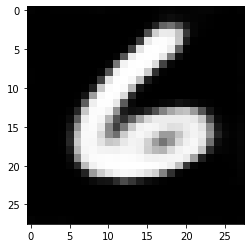

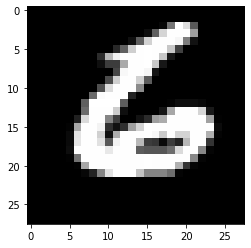

epoch: 1 out of 30
train_loss: 0.01701178317864736	 val_loss:0.016284609209001065


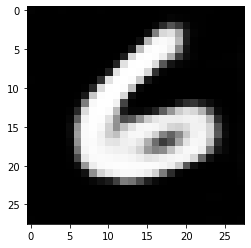

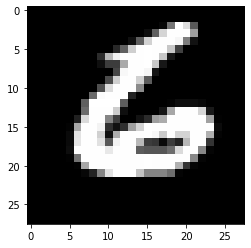

epoch: 2 out of 30
train_loss: 0.014993068515261014	 val_loss:0.014231190370023251


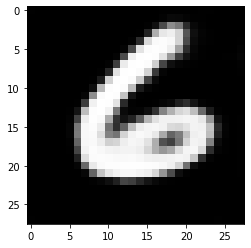

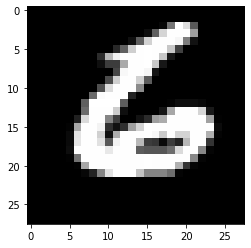

epoch: 3 out of 30
train_loss: 0.01388163857460022	 val_loss:0.013517993414402008


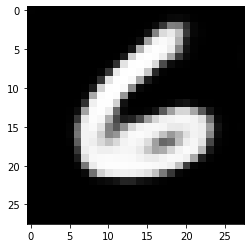

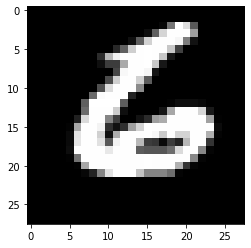

epoch: 4 out of 30
train_loss: 0.013167388868331908	 val_loss:0.013119763587415218


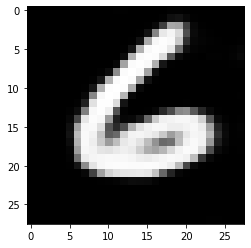

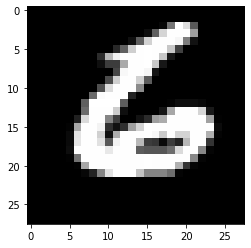

epoch: 5 out of 30
train_loss: 0.012620194697876772	 val_loss:0.012574772886931896


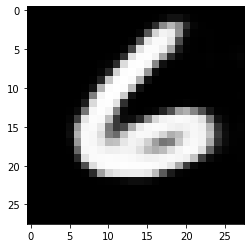

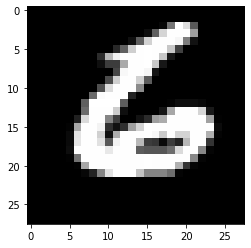

epoch: 6 out of 30
train_loss: 0.01216435292015473	 val_loss:0.012328111082315445


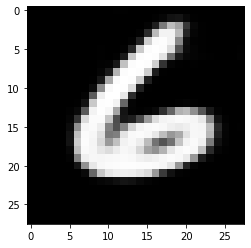

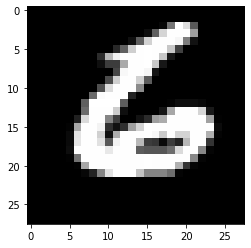

epoch: 7 out of 30
train_loss: 0.01184070248156786	 val_loss:0.011897015137970448


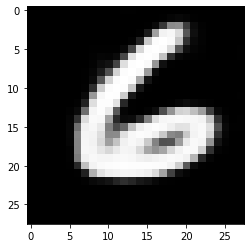

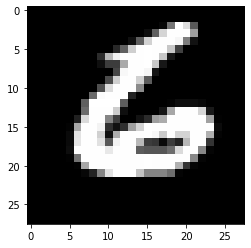

epoch: 8 out of 30
train_loss: 0.011521184627215068	 val_loss:0.011584854523837566


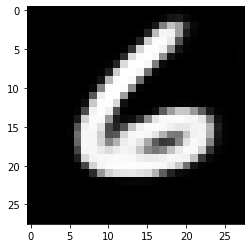

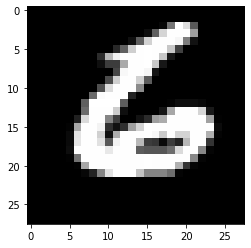

epoch: 9 out of 30
train_loss: 0.011279536365469297	 val_loss:0.011598710031807423


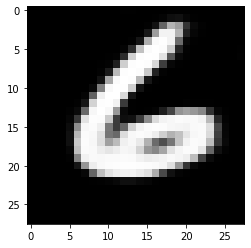

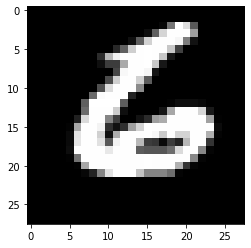

epoch: 10 out of 30
train_loss: 0.011069915487865607	 val_loss:0.011280293856561183


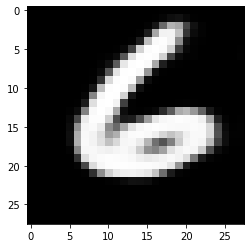

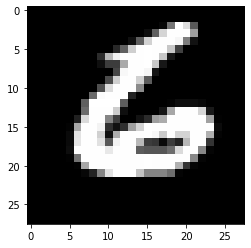

epoch: 11 out of 30
train_loss: 0.01089820352991422	 val_loss:0.011516811893880367


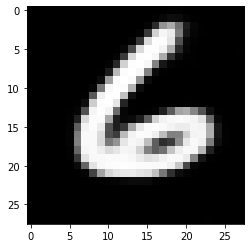

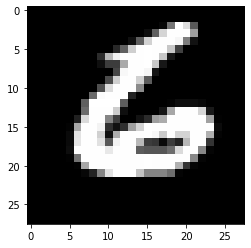

epoch: 12 out of 30
train_loss: 0.010727750810980798	 val_loss:0.011064908814430237


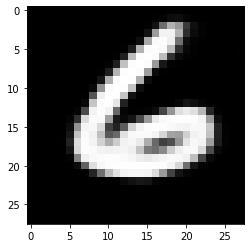

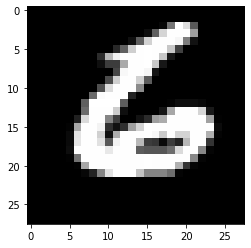

epoch: 13 out of 30
train_loss: 0.010532089530428251	 val_loss:0.010914755676686764


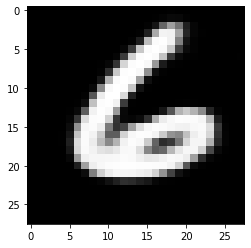

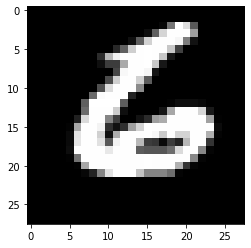

epoch: 14 out of 30
train_loss: 0.01043606148113807	 val_loss:0.01078114202618599


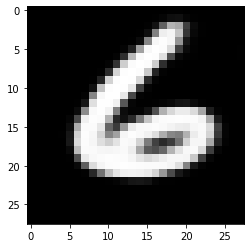

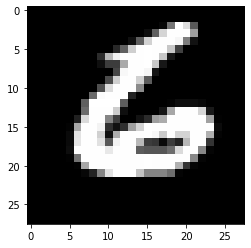

epoch: 15 out of 30
train_loss: 0.01029697048564752	 val_loss:0.01125265988856554


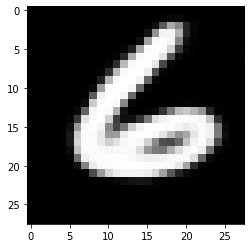

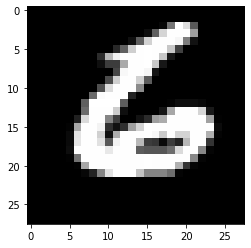

epoch: 16 out of 30
train_loss: 0.01020230845361948	 val_loss:0.010863549023866654


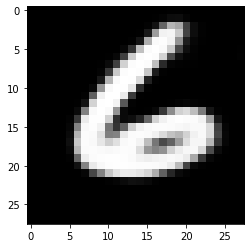

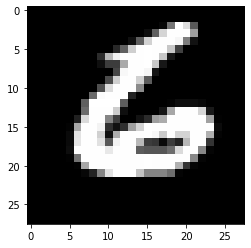

epoch: 17 out of 30
train_loss: 0.010114918258289496	 val_loss:0.01060491032153368


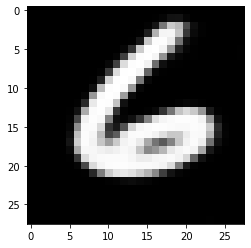

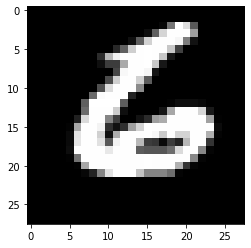

epoch: 18 out of 30
train_loss: 0.009997582920392354	 val_loss:0.011177666054666042


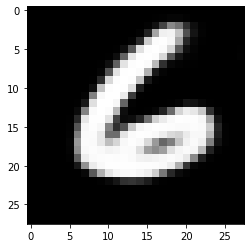

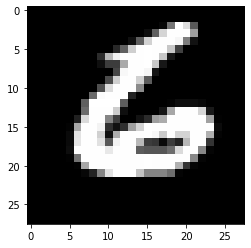

epoch: 19 out of 30
train_loss: 0.009919069794813792	 val_loss:0.010789608019590377


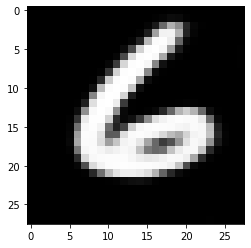

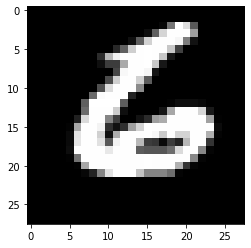

epoch: 20 out of 30
train_loss: 0.009845020925501982	 val_loss:0.010465166643261909


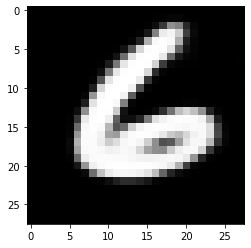

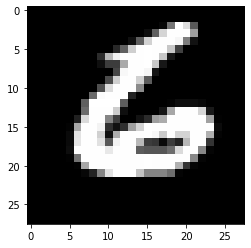

epoch: 21 out of 30
train_loss: 0.009771051480372746	 val_loss:0.010557737600803375


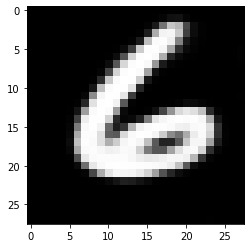

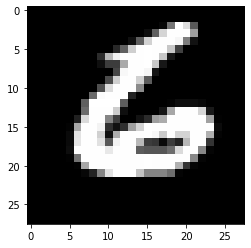

epoch: 22 out of 30
train_loss: 0.009678935902317365	 val_loss:0.01041077750325203


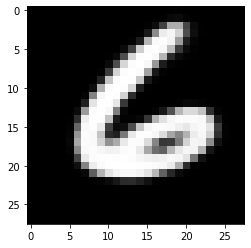

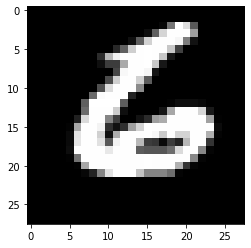

epoch: 23 out of 30
train_loss: 0.009609043012062708	 val_loss:0.010262519031763076


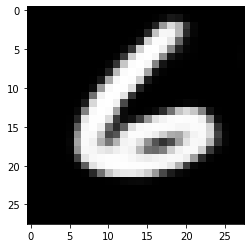

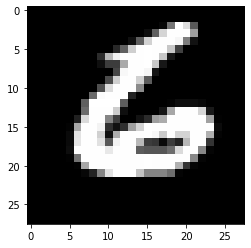

epoch: 24 out of 30
train_loss: 0.009559609930217266	 val_loss:0.010372821216285228


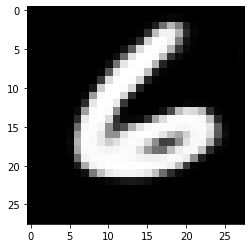

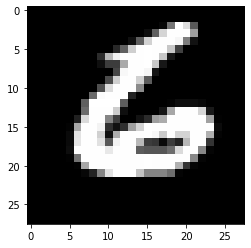

epoch: 25 out of 30
train_loss: 0.009490091039737065	 val_loss:0.010259165884554387


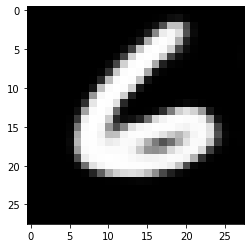

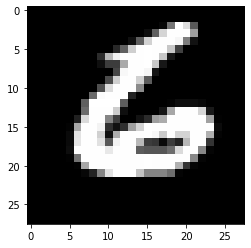

epoch: 26 out of 30
train_loss: 0.009429265081882477	 val_loss:0.010270008085668088


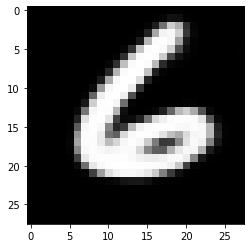

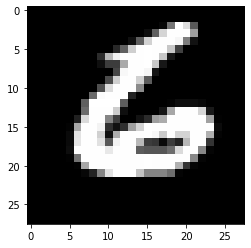

epoch: 27 out of 30
train_loss: 0.00937559829056263	 val_loss:0.010211589117348194


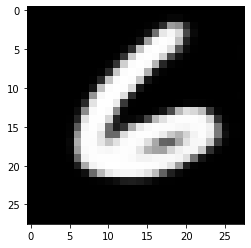

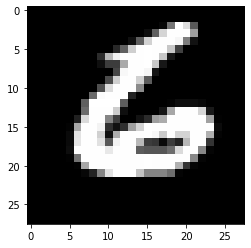

epoch: 28 out of 30
train_loss: 0.00930678537239631	 val_loss:0.01031772422939539


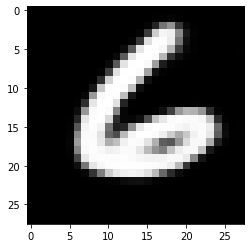

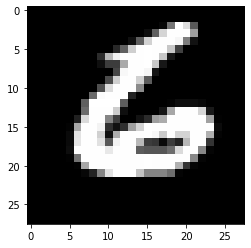

epoch: 29 out of 30
train_loss: 0.009273977389931678	 val_loss:0.010142783614993095


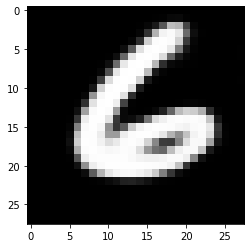

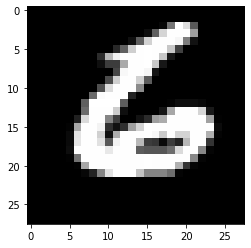

epoch: 30 out of 30
train_loss: 0.00923673415184021	 val_loss:0.010415644745528698


In [49]:
best, train_losses, val_losses = train(valloader, trainloader, 30)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [50]:
def sampling(number):
    z = torch.randn(1, Latent)*0.1
    condition = OneHot(1, torch.IntTensor([number]), Latent)
    with torch.no_grad():
        autoencoder_mnist.eval()
        output = autoencoder_mnist.decoder_(z.to(DEVICE), condition.to(DEVICE))
        plt.imshow(output.squeeze_(0)[0].cpu().numpy(), cmap='gray')
        plt.show()
    for i in range(10):
        sampling(i)

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [51]:
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.6/dist-packages/

--2020-07-03 15:54:46--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.93.24, 104.17.92.24, 2606:4700::6811:5c18, ...
Connecting to anaconda.org (anaconda.org)|104.17.93.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5d019c23c7424a015486440c/5d790a95778a870c42137059?response-content-disposition=attachment%3B%20filename%3D%22tsnecuda-2.1.0-cuda100.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27tsnecuda-2.1.0-cuda100.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20200703T155446Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEN7%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIBwdUKmFdARytgD7TGo3Q%2BRHUaDUGdYVOh3ygJeGbVmHAiEAgmjEKpI9jMJUudVCOjZmWqkNLMZxknDf1EAg8hO%2FQokqtAMIdxAAGgw0NTU4NjQwOTgzNzgiDBBbYOjpmXdpoYDtrCqRAyjievSwO00hGVJ

In [52]:
!echo $LD_LIBRARY_PATH 
# this is probably /usr/lib64-nvidia

!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so

/usr/lib64-nvidia


In [53]:
autoencoder_mnist.eval()
output = np.array((64*10)*[]).reshape(-1, 10)
labels = np.array((64*[]))
with torch.no_grad():
    for X, y in trainloader:
        output = np.concatenate((autoencoder_mnist.encoder_(X.view(-1, 28*28).to(DEVICE), OneHot(len(X), y, 28*28).to(DEVICE)).cpu().numpy(), output), axis = 0)
        labels = np.concatenate((y.cpu().numpy(), labels))

In [54]:
import tsnecuda
tsnecuda.test()

In [55]:
from tsnecuda import TSNE as TSNE_CUDA
tsne_cuda = TSNE_CUDA(
    n_components=2, 
    perplexity=30.0, 
    early_exaggeration=12.0, 
    learning_rate=200.0, 
    n_iter=1000, 
    n_iter_without_progress=300, 
    min_grad_norm=1e-07, 
    metric='euclidean', 
    init='random', 
    verbose=0,
    random_seed=None, # different parameter name
    theta=0.5 # different parameter name
)

In [57]:
!pip install numpy==1.16.4

     |████████████████████████████████| 17.3MB 200kB/s 
ERROR: umap-learn 0.4.4 has requirement numpy>=1.17, but you'll have numpy 1.16.4 which is incompatible.
ERROR: umap-learn 0.4.4 has requirement scipy>=1.3.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.0.0 which is incompatible.
ERROR: seaborn 0.10.1 has requirement scipy>=1.0.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.0.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: cvxpy 1.0.31 has requirement scipy>=1.1.0, but you'll have scipy 1.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18

In [58]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scaled = scale.fit_transform(output[:4000])
result = tsne_cuda.fit_transform(scaled)

In [59]:
data = pd.DataFrame(result, index = labels[:4000])
data.head()

,0,1
0.0,12.031195,28.326536
0.0,2.573766,27.292385
9.0,-1.441051,-11.788242
9.0,16.951540,0.952088
1.0,-21.151264,-10.433690


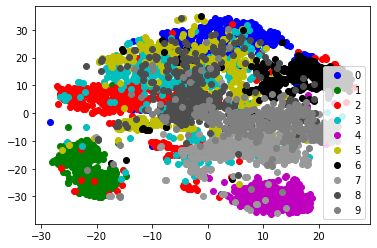

In [60]:
fig, ax = plt.subplots()

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '0.6', '0.3', '0.5']
for i in range(10):
    ax.scatter(data.loc[i][0].values, data.loc[i][1].values, c=colors[i], label = i)
plt.legend()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Более четкие кластеры

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


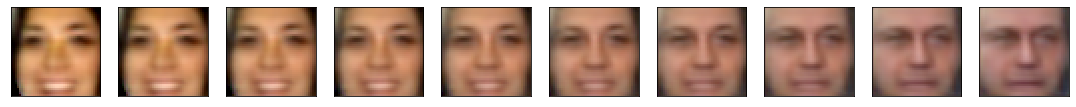

In [ ]:
first_person_code = happy_code[2]
second_person_code = sad_code[9]
code_sequence = []

num = 10
for i in np.linspace(0, 1, num):
  code_sequence.append((1 - i) * first_person_code + i * second_person_code)

code_sequence = torch.stack(code_sequence)

decoder.eval()
img_sequence = decoder(code_sequence.to(device)).detach().cpu()
img_sequence = np.rollaxis(img_sequence.numpy(), 1, 4)
plot_gallery(img_sequence, IMAGE_H, IMAGE_W, n_row=1, n_col=num)

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
X = data

In [ ]:
noise_factor = 50
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
Y_train = X[tr]
Y_val = X[val]
X_train = X_noisy[tr]
X_val = X_noisy[val]

X_train = np.array(X_train, np.float32) / 255
X_val = np.array(X_val, np.float32) / 255
Y_train = np.array(Y_train, np.float32) / 255
Y_val = np.array(Y_val, np.float32) / 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

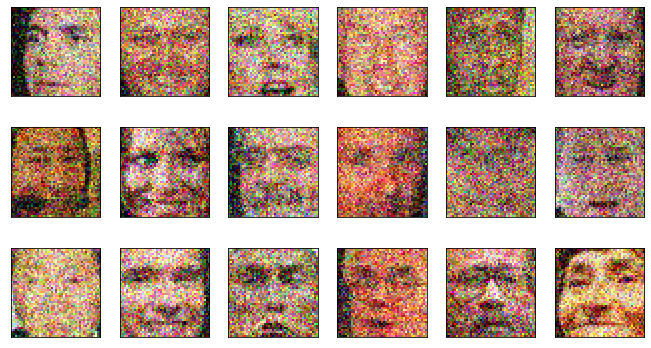

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20

data_tr = DataLoader(list(zip(np.rollaxis(X_train, 3, 1),
                          np.rollaxis(Y_train, 3, 1))), 
                          batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X_val, 3, 1), 
                           np.rollaxis(Y_val, 3, 1))),
                           batch_size=batch_size, shuffle=True)

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    tr_loss = []
    val_loss = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            Y_pred, code = model(X_batch)
            Y_pred = Y_pred.to(device)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()

            avg_loss += loss / len(data_tr)
        tr_loss.append(avg_loss)
        toc = time()
        print('loss: %f' % avg_loss)

        model.eval()
        reconstruction, code = model(X_val.to(device))

        reconstruction = reconstruction.detach().cpu()
        val_loss.append(loss_fn(Y_val, reconstruction))

        # Visualize tools
        clear_output(wait=True)
        plot_gallery([np.rollaxis(X_val[0].numpy(), 0, 3), np.rollaxis(reconstruction[0].numpy(), 0, 3)], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return tr_loss, val_loss

In [ ]:
tr_loss, val_loss = train(model, optimizer, criterion, 25, data_tr, data_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


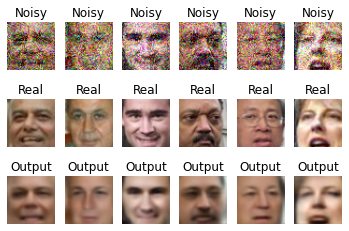

In [ ]:
num = 6
model.eval()

x_val, y_val = next(iter(data_val))
y_hat, code = model(x_val.to(device))
y_hat = y_hat.detach().cpu()

for k in range(num):
    plt.subplot(3, num, k + 1)
    plt.imshow(np.rollaxis(x_val[k].numpy(), 0, 3))
    plt.title('Noisy')
    plt.axis('off')

    plt.subplot(3, num, k + 7)
    plt.imshow(np.rollaxis(y_val[k].numpy(), 0, 3))
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, num, k + 13)
    plt.imshow(np.rollaxis(y_hat[k].numpy(), 0, 3))
    plt.title('Output')
    plt.axis('off')
plt.show()

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
X = data

In [ ]:
mask = np.array([255]*10*10*3).reshape(10,10, 3)

x, y = np.random.randint(0, 30, size=(2, len(X)))

#Replace original image with white box
X_occl = X.copy()
for i in range(len(X)):
  X_occl[i, x[i]:x[i]+10, y[i]:y[i]+10, :] = mask

In [ ]:
Y_train = X[tr]
Y_val = X[val]
X_train = X_occl[tr]
X_val = X_occl[val]

X_train = np.array(X_train, np.float32) / 255
X_val = np.array(X_val, np.float32) / 255
Y_train = np.array(Y_train, np.float32) / 255
Y_val = np.array(Y_val, np.float32) / 255

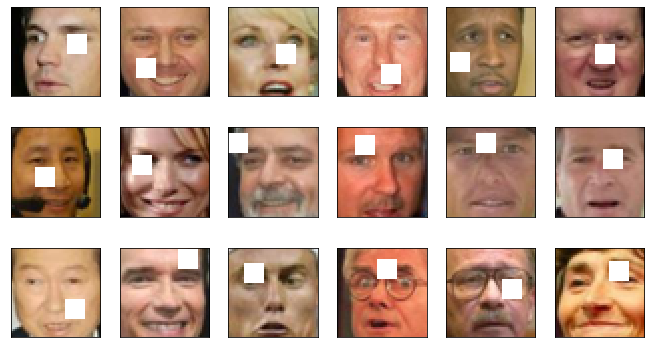

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20

data_tr = DataLoader(list(zip(np.rollaxis(X_train, 3, 1),
                          np.rollaxis(Y_train, 3, 1))), 
                          batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X_val, 3, 1), 
                           np.rollaxis(Y_val, 3, 1))),
                           batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


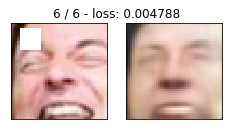

In [ ]:
tr_loss, val_loss = train(model, optimizer, criterion, 6, data_tr, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


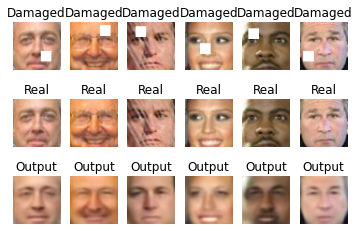

In [ ]:
num = 6
model.eval()

x_val, y_val = next(iter(data_val))
y_hat, code = model(x_val.to(device))
y_hat = y_hat.detach().cpu()

for k in range(num):
    plt.subplot(3, num, k + 1)
    plt.imshow(np.rollaxis(x_val[k].numpy(), 0, 3))
    plt.title('Damaged')
    plt.axis('off')

    plt.subplot(3, num, k + 7)
    plt.imshow(np.rollaxis(y_val[k].numpy(), 0, 3))
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, num, k + 13)
    plt.imshow(np.rollaxis(y_hat[k].numpy(), 0, 3))
    plt.title('Output')
    plt.axis('off')
plt.show()

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!